


## Deep Learning Course Project - Gesture Recognition

### Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
 
| Gesture | Corresponding Action |
| --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |

Each video is a sequence of 30 frames (or images).


In [31]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [32]:
pip install opencv-python


Note: you may need to restart the kernel to use updated packages.


We set the random seed so that the results don't vary drastically.

In [5]:
current_working_directory = os.getcwd()
print(current_working_directory)

/Users/anuraag/Desktop/upgrad/gesture/Gesture-Recognition-Case-study-IIITB-Assignment--master


In [6]:
project_folder = 'Project_data'
project_folder = os.path.join(current_working_directory, 'Project_data')

##### Plotting

In [7]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [9]:

import numpy as np
import random as rn
import tensorflow as tf
import imageio
from PIL import Image
import os
import cv2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import abc
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, BatchNormalization, Activation
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss', 'val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy', 'val_categorical_accuracy'])

class ModelBuilder(metaclass=abc.ABCMeta):
    # initializing the path where project data resides
    def initialize_path(self, project_folder):
        train_csv_path = os.path.join(project_folder, 'train.csv')
        val_csv_path = os.path.join(project_folder, 'val.csv')
        self.train_doc = np.random.permutation(open(train_csv_path).readlines())
        self.val_doc = np.random.permutation(open(val_csv_path).readlines())
        self.train_path = os.path.join(project_folder, 'train')
        self.val_path = os.path.join(project_folder, 'val')
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
    
    # initializing the image properties    
    def initialize_image_properties(self, image_height=100, image_width=100):
        self.image_height = image_height
        self.image_width = image_width
        self.channels = 3
        self.num_classes = 5
        self.total_frames = 30
    
    # initializing the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self, frames_to_sample=30, batch_size=20, num_epochs=20):
        self.frames_to_sample = frames_to_sample
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        
    # MOST IMPORTANT PART HERE - The generator function        
    def generator(self, source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0, self.total_frames-1, self.frames_to_sample)).astype(int)
        batch_size = self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t) // batch_size

            for batch in range(num_batches): 
                batch_data, batch_labels = self.one_batch_data(source_path, t, batch, batch_size, img_idx, augment)
                yield batch_data, batch_labels 

            remaining_seq = len(t) % batch_size

            if remaining_seq != 0:
                batch_data, batch_labels = self.one_batch_data(source_path, t, num_batches, batch_size, img_idx, augment, remaining_seq)
                yield batch_data, batch_labels 
    
    def one_batch_data(self, source_path, t, batch, batch_size, img_idx, augment, remaining_seq=0):
        seq_len = remaining_seq if remaining_seq else batch_size
        batch_data = np.zeros((seq_len, len(img_idx), self.image_height, self.image_width, self.channels)) 
        batch_labels = np.zeros((seq_len, self.num_classes)) 
        if augment:
            batch_data_aug = np.zeros((seq_len, len(img_idx), self.image_height, self.image_width, self.channels))

        for folder in range(seq_len): 
            imgs = os.listdir(os.path.join(source_path, t[folder + (batch * batch_size)].split(';')[0])) 
            for idx, item in enumerate(img_idx):
                # Perform image reading and resizing
                image_path = os.path.join(source_path, t[folder + (batch * batch_size)].strip().split(';')[0], imgs[item])
                image = imageio.imread(image_path).astype(np.uint8)
                image_resized = np.array(Image.fromarray(image).resize((self.image_height, self.image_width)))

                # Normalizing the images
                batch_data[folder, idx, :, :, 0] = (image_resized[:, :, 0]) / 255
                batch_data[folder, idx, :, :, 1] = (image_resized[:, :, 1]) / 255
                batch_data[folder, idx, :, :, 2] = (image_resized[:, :, 2]) / 255

                if augment:
                    shifted = cv2.warpAffine(image, np.float32([[1, 0, np.random.randint(-30, 30)], [0, 1, np.random.randint(-30, 30)]]), (image.shape[1], image.shape[0]))
                    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    cropped = shifted[x0:x1, y0:y1, :]
                    image_resized = np.array(Image.fromarray(cropped.astype(np.uint8)).resize((self.image_height, self.image_width)))

                    batch_data_aug[folder, idx, :, :, 0] = (image_resized[:, :, 0]) / 255
                    batch_data_aug[folder, idx, :, :, 1] = (image_resized[:, :, 1]) / 255
                    batch_data_aug[folder, idx, :, :, 2] = (image_resized[:, :, 2]) / 255

            batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1

        if augment:
            batch_data = np.concatenate([batch_data, batch_data_aug])
            batch_labels = np.concatenate([batch_labels, batch_labels])

        return batch_data, batch_labels
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc, augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=10, verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences % self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences / self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences // self.batch_size) + 1

        if (self.num_val_sequences % self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences / self.batch_size)
        else:
            validation_steps = (self.num_val_sequences // self.batch_size) + 1

        history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, initial_epoch=0)
        return history

    @abc.abstractmethod
    def define_model(self):
        pass


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Sample Model

In [119]:
class ModelConv3D1(ModelBuilder):
    def define_model(self):
        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same', input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(1, 2, 2)))  # Adjusted pooling size

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(1, 2, 2)))  # Adjusted pooling size

        model.add(Conv3D(64, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(1, 2, 2)))  # Adjusted pooling size

        model.add(Conv3D(128, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(1, 2, 2)))  # Adjusted pooling size

        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))

        model.add(Dense(self.num_classes, activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [120]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_72 (Conv3D)              │ (None, 30, 160, 160,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_72 (Activation)      │ (None, 30, 160, 160,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_108         │ (None, 30, 160, 160,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_72 (MaxPooling3D) │ (None, 30, 80, 80, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_73 (Conv3D)              │ (None, 30, 80, 80, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_73 (Activation)      │ (None, 30, 80, 80, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_109         │ (None, 30, 80, 80, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_73 (MaxPooling3D) │ (None, 30, 40, 40, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_74 (Conv3D)              │ (None, 30, 40, 40, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_74 (Activation)      │ (None, 30, 40, 40, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_110         │ (None, 30, 40, 40, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_74 (MaxPooling3D) │ (None, 30, 20, 20, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_75 (Conv3D)              │ (None, 30, 20, 20,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_75 (Activation)      │ (None, 30, 20, 20,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_111         │ (None, 30, 20, 20,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_75 (MaxPooling3D) │ (None, 30, 10, 10,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 384000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 128)            │    49,152,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_112         │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 128)            │             

 Total params: 49,454,277 (188.65 MB)

 Trainable params: 49,453,413 (188.65 MB)

 Non-trainable params: 864 (3.38 KB)

##### Sample Cropping

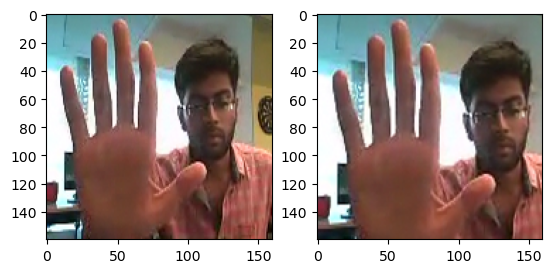

In [121]:
test_generator=ModelConv3D1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])   

## Experimenting with Image resolution, number of frames to use and batch_size

In [122]:
#conv_3d1.train_model(conv_3d1_model)

##### So lets trade-off between these parameters

##### Below are the experiments to see how training time is affected by image resolution, number of images in sequence and batch size

In [123]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=15,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 9149637
Epoch 1/2
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.3609 - loss: 1.8319
Epoch 1: val_loss improved from inf to 3.47556, saving model to model_init_2024-07-0123_23_49.980676/model-00001-1.58340-0.42232-3.47556-0.23000.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 113s 5s/step - categorical_accuracy: 0.3634 - loss: 1.8216 - val_categorical_accuracy: 0.2300 - val_loss: 3.4756 - learning_rate: 0.0010
Epoch 2/2
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - categorical_accuracy: 0.5618 - loss: 1.1575 
Epoch 2: val_loss improved from 3.47556 to 2.29360, saving model to model_init_2024-07-0123_23_49.980676/model-00002-1.17988-0.54600-2.29360-0.17000.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 305s 14s/step - categorical_accuracy: 0.5611 - loss: 1.1584 - val_categorical_accuracy: 0.1700 - val_loss: 2.2936 - learning_rate: 0.0010


In [124]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 17996997
Epoch 1/2
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - categorical_accuracy: 0.3260 - loss: 2.0110
Epoch 1: val_loss improved from inf to 5.00084, saving model to model_init_2024-07-0123_30_55.231047/model-00001-1.77102-0.37707-5.00084-0.24000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 234s 7s/step - categorical_accuracy: 0.3274 - loss: 2.0041 - val_categorical_accuracy: 0.2400 - val_loss: 5.0008 - learning_rate: 0.0010
Epoch 2/2
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.4005 - loss: 1.5057
Epoch 2: val_loss improved from 5.00084 to 2.90696, saving model to model_init_2024-07-0123_30_55.231047/model-00002-1.48579-0.42986-2.90696-0.21000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 226s 7s/step - categorical_accuracy: 0.4013 - loss: 1.5052 - val_categorical_accuracy: 0.2100 - val_loss: 2.9070 - learning_rate: 0.0010


In [125]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 49454277
Epoch 1/2
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - categorical_accuracy: 0.3372 - loss: 1.8816 
Epoch 1: val_loss improved from inf to 4.75765, saving model to model_init_2024-07-0123_38_37.411371/model-00001-1.76267-0.36953-4.75765-0.18000.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 612s 14s/step - categorical_accuracy: 0.3379 - loss: 1.8790 - val_categorical_accuracy: 0.1800 - val_loss: 4.7576 - learning_rate: 0.0010
Epoch 2/2
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - categorical_accuracy: 0.4869 - loss: 1.4163 
Epoch 2: val_loss improved from 4.75765 to 3.60672, saving model to model_init_2024-07-0123_38_37.411371/model-00002-1.38407-0.50075-3.60672-0.32000.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 595s 13s/step - categorical_accuracy: 0.4872 - loss: 1.4156 - val_categorical_accuracy: 0.3200 - val_loss: 3.6067 - learning_rate: 0.0010


In [126]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 26516677
Epoch 1/2
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - categorical_accuracy: 0.3393 - loss: 1.8194 
Epoch 1: val_loss improved from inf to 7.56187, saving model to model_init_2024-07-0123_58_45.766364/model-00001-1.66994-0.38914-7.56187-0.18000.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 322s 14s/step - categorical_accuracy: 0.3413 - loss: 1.8131 - val_categorical_accuracy: 0.1800 - val_loss: 7.5619 - learning_rate: 0.0010
Epoch 2/2
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - categorical_accuracy: 0.5064 - loss: 1.3697 
Epoch 2: val_loss did not improve from 7.56187
23/23 ━━━━━━━━━━━━━━━━━━━━ 323s 14s/step - categorical_accuracy: 0.5069 - loss: 1.3661 - val_categorical_accuracy: 0.2200 - val_loss: 8.2517 - learning_rate: 0.0010


- As we see from the above experiments **"image resolution"** and **number of frames** in sequence have more impact on training time than **batch_size**
- We can consider the Batch Size around 15-40
- We will change the resoulution 160*160, 120*120 according the model performance


## Model 1
### Base Model - Batch Size = 40 and No. of Epochs = 15

In [127]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [128]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_92 (Conv3D)              │ (None, 20, 160, 160,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_92 (Activation)      │ (None, 20, 160, 160,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_138         │ (None, 20, 160, 160,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_92 (MaxPooling3D) │ (None, 10, 80, 80, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_93 (Conv3D)              │ (None, 10, 80, 80, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_93 (Activation)      │ (None, 10, 80, 80, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_139         │ (None, 10, 80, 80, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_93 (MaxPooling3D) │ (None, 5, 40, 40, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_94 (Conv3D)              │ (None, 5, 40, 40, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_94 (Activation)      │ (None, 5, 40, 40, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_140         │ (None, 5, 40, 40, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_94 (MaxPooling3D) │ (None, 2, 20, 20, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_95 (Conv3D)              │ (None, 2, 20, 20, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_95 (Activation)      │ (None, 2, 20, 20, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_141         │ (None, 2, 20, 20, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_95 (MaxPooling3D) │ (None, 1, 10, 10, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_23 (Flatten)            │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 64)             │       819,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_142         │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,117,061 (4.26 MB)

 Trainable params: 1,116,325 (4.26 MB)

 Non-trainable params: 736 (2.88 KB)

In [129]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - categorical_accuracy: 0.3331 - loss: 1.8406 
Epoch 1: val_loss improved from inf to 1.71198, saving model to model_init_2024-07-0200_09_33.241778/model-00001-1.59889-0.41931-1.71198-0.23000.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 244s 14s/step - categorical_accuracy: 0.3379 - loss: 1.8272 - val_categorical_accuracy: 0.2300 - val_loss: 1.7120 - learning_rate: 0.0010
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - categorical_accuracy: 0.5654 - loss: 1.1238 
Epoch 2: val_loss did not improve from 1.71198
17/17 ━━━━━━━━━━━━━━━━━━━━ 243s 14s/step - categorical_accuracy: 0.5665 - loss: 1.1238 - val_categorical_accuracy: 0.2300 - val_loss: 2.0671 - learning_rate: 0.0010
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - categorical_accuracy: 0.6619 - loss: 0.8320 
Epoch 3: val_loss did not improve from 1.71198
17/17 ━━━━━━━━━━━━━━━━━━━━ 232s 14s/step - categorical_accuracy: 0.6614 - loss: 0.8345 - val_categorical_accurac

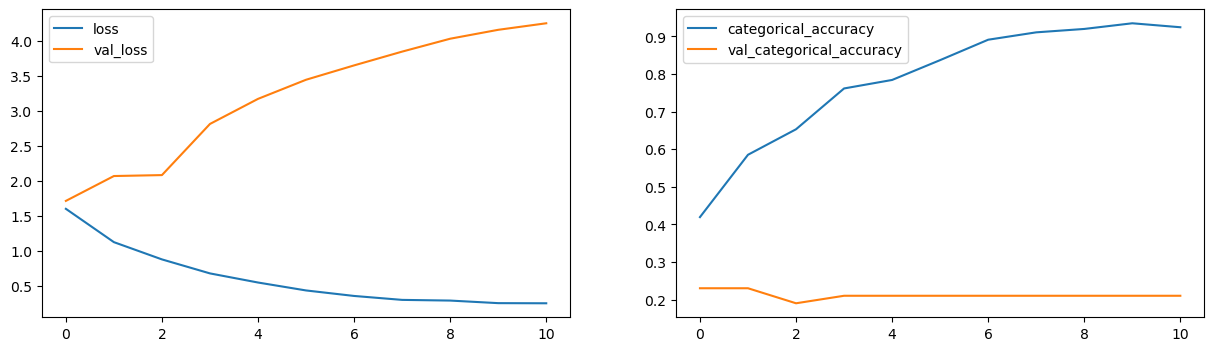

In [130]:
plot(history_model1)

## Model 2  
### Adding dropout layers - Batch Size = 20 and No. of Epochs = 25

In [131]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_96 (Conv3D)              │ (None, 20, 160, 160,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_96 (Activation)      │ (None, 20, 160, 160,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_144         │ (None, 20, 160, 160,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_96 (MaxPooling3D) │ (None, 10, 80, 80, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_97 (Conv3D)              │ (None, 10, 80, 80, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_97 (Activation)      │ (None, 10, 80, 80, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_145         │ (None, 10, 80, 80, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_97 (MaxPooling3D) │ (None, 5, 40, 40, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_98 (Conv3D)              │ (None, 5, 40, 40, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_98 (Activation)      │ (None, 5, 40, 40, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_146         │ (None, 5, 40, 40, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_98 (MaxPooling3D) │ (None, 2, 20, 20, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_99 (Conv3D)              │ (None, 2, 20, 20, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_99 (Activation)      │ (None, 2, 20, 20, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_147         │ (None, 2, 20, 20, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_99 (MaxPooling3D) │ (None, 1, 10, 10, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_148         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,638,981 (13.88 MB)

 Trainable params: 3,637,477 (13.88 MB)

 Non-trainable params: 1,504 (5.88 KB)

In [132]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 3638981
Epoch 1/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - categorical_accuracy: 0.3567 - loss: 2.1266 
Epoch 1: val_loss improved from inf to 3.49374, saving model to model_init_2024-07-0201_29_54.892810/model-00001-1.86055-0.40950-3.49374-0.20000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 494s 14s/step - categorical_accuracy: 0.3582 - loss: 2.1190 - val_categorical_accuracy: 0.2000 - val_loss: 3.4937 - learning_rate: 0.0010
Epoch 2/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 45s/step - categorical_accuracy: 0.5394 - loss: 1.3213 
Epoch 2: val_loss did not improve from 3.49374
34/34 ━━━━━━━━━━━━━━━━━━━━ 1502s 45s/step - categorical_accuracy: 0.5393 - loss: 1.3218 - val_categorical_accuracy: 0.2300 - val_loss: 4.9627 - learning_rate: 0.0010
Epoch 3/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 39s/step - categorical_accuracy: 0.5498 - loss: 1.2861 
Epoch 3: val_loss did not improve from 3.49374
34/34 ━━━━━━━━━━━━━━━━━━━━ 1300s 39s/step - categorical_accuracy: 0.5498 - loss: 1.2860 - val_categorical_accur

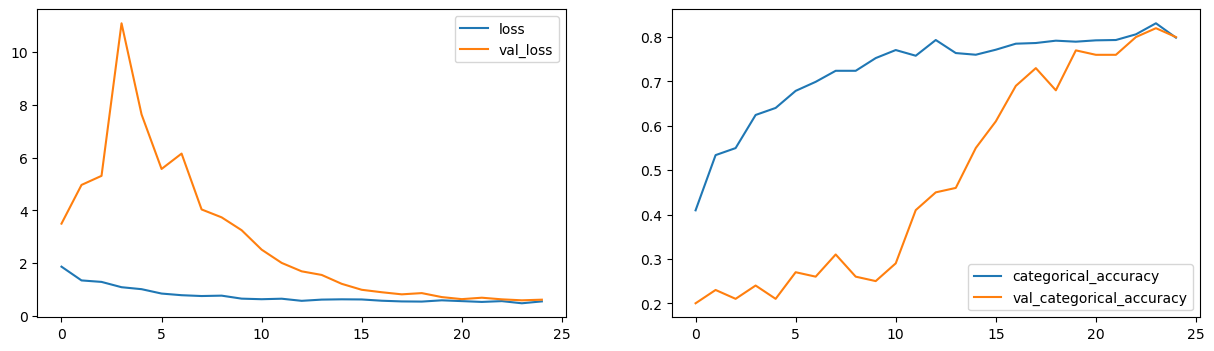

In [133]:
plot(history_model2)

## Model 3 
### Reduce filter size to (2,2,2) and image res to 120 x  120, - Batch Size = 30 and No. of Epochs = 25

In [138]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self, filtersize=(3, 3, 3), dense_neurons=64, dropout=0.25):
        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                         input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [139]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_108 (Conv3D)             │ (None, 16, 120, 120,   │           400 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_108 (Activation)     │ (None, 16, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_162         │ (None, 16, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_108               │ (None, 8, 60, 60, 16)  │             0 │
│ (MaxPooling3D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_109 (Conv3D)             │ (None, 8, 60, 60, 32)  │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_109 (Activation)     │ (None, 8, 60, 60, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_163         │ (None, 8, 60, 60, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_109               │ (None, 4, 30, 30, 32)  │             0 │
│ (MaxPooling3D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_110 (Conv3D)             │ (None, 4, 30, 30, 64)  │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_110 (Activation)     │ (None, 4, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_164         │ (None, 4, 30, 30, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_110               │ (None, 2, 15, 15, 64)  │             0 │
│ (MaxPooling3D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_111 (Conv3D)             │ (None, 2, 15, 15, 128) │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_111 (Activation)     │ (None, 2, 15, 15, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_165         │ (None, 2, 15, 15, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_111               │ (None, 1, 7, 7, 128)   │             0 │
│ (MaxPooling3D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_27 (Flatten)            │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_166         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,762,613 (6.72 MB)

 Trainable params: 1,761,109 (6.72 MB)

 Non-trainable params: 1,504 (5.88 KB)

In [140]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 1762613
Epoch 1/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - categorical_accuracy: 0.2808 - loss: 2.3621 
Epoch 1: val_loss improved from inf to 1.84500, saving model to model_init_2024-07-0213_13_30.435039/model-00001-2.13593-0.32051-1.84500-0.16000.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 509s 23s/step - categorical_accuracy: 0.2824 - loss: 2.3527 - val_categorical_accuracy: 0.1600 - val_loss: 1.8450 - learning_rate: 2.0000e-04
Epoch 2/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.4610 - loss: 1.5678
Epoch 2: val_loss did not improve from 1.84500
23/23 ━━━━━━━━━━━━━━━━━━━━ 142s 6s/step - categorical_accuracy: 0.4619 - loss: 1.5652 - val_categorical_accuracy: 0.1800 - val_loss: 2.8102 - learning_rate: 2.0000e-04
Epoch 3/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.5050 - loss: 1.4188
Epoch 3: val_loss did not improve from 1.84500
23/23 ━━━━━━━━━━━━━━━━━━━━ 149s 6s/step - categorical_accuracy: 0.5059 - loss: 1.4172 - val_categorical_accur

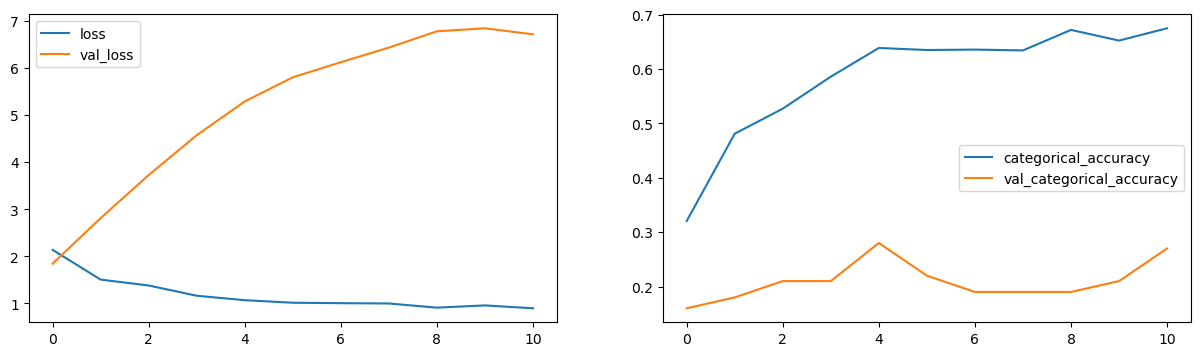

In [141]:
plot(history_model3)

## Model 4 - 
### Adding more layers - Batch Size = 20 and No. of Epochs = 25

In [142]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [143]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_112 (Conv3D)             │ (None, 16, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_112 (Activation)     │ (None, 16, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_168         │ (None, 16, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_113 (Conv3D)             │ (None, 16, 120, 120,   │         6,928 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_113 (Activation)     │ (None, 16, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_169         │ (None, 16, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_112               │ (None, 8, 60, 60, 16)  │             0 │
│ (MaxPooling3D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_114 (Conv3D)             │ (None, 8, 60, 60, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_114 (Activation)     │ (None, 8, 60, 60, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_170         │ (None, 8, 60, 60, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_115 (Conv3D)             │ (None, 8, 60, 60, 32)  │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_115 (Activation)     │ (None, 8, 60, 60, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_171         │ (None, 8, 60, 60, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_113               │ (None, 4, 30, 30, 32)  │             0 │
│ (MaxPooling3D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_116 (Conv3D)             │ (None, 4, 30, 30, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_116 (Activation)     │ (None, 4, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_172         │ (None, 4, 30, 30, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_117 (Conv3D)             │ (None, 4, 30, 30, 64)  │       110,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_117 (Activation)     │ (None, 4, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,556,533 (9.75 MB)

 Trainable params: 2,554,549 (9.74 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [144]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - categorical_accuracy: 0.3242 - loss: 2.1827 
Epoch 1: val_loss improved from inf to 1.92208, saving model to model_init_2024-07-0213_48_17.514295/model-00001-2.02560-0.37029-1.92208-0.32000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 393s 12s/step - categorical_accuracy: 0.3255 - loss: 2.1782 - val_categorical_accuracy: 0.3200 - val_loss: 1.9221 - learning_rate: 0.0010
Epoch 2/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - categorical_accuracy: 0.4726 - loss: 1.5521 
Epoch 2: val_loss did not improve from 1.92208
34/34 ━━━━━━━━━━━━━━━━━━━━ 390s 11s/step - categorical_accuracy: 0.4733 - loss: 1.5504 - val_categorical_accuracy: 0.1800 - val_loss: 2.8693 - learning_rate: 0.0010
Epoch 3/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - categorical_accuracy: 0.5435 - loss: 1.4107 
Epoch 3: val_loss did not improve from 1.92208
34/34 ━━━━━━━━━━━━━━━━━━━━ 399s 12s/step - categorical_accuracy: 0.5436 - loss: 1.4084 - val_categorical_accurac

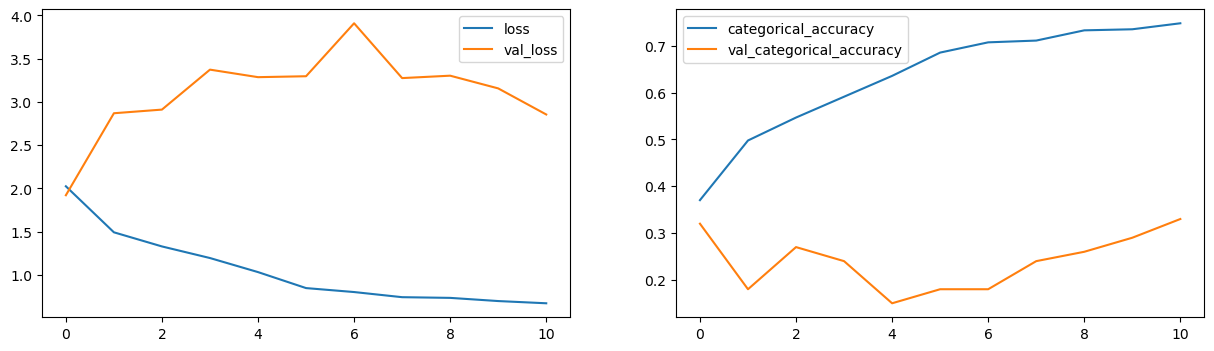

In [145]:
plot(history_model4)

##### With more layers we dont see much performance improvement. We get a best validation accuracy of 76% . Let's try adding dropouts at the convolution layers

## Model 5 
### Adding dropout at convolution layers

In [146]:
class ModelConv3D5(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [147]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=15)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_120 (Conv3D)             │ (None, 16, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_120 (Activation)     │ (None, 16, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_178         │ (None, 16, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_121 (Conv3D)             │ (None, 16, 120, 120,   │         6,928 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_121 (Activation)     │ (None, 16, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_179         │ (None, 16, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_116               │ (None, 8, 60, 60, 16)  │             0 │
│ (MaxPooling3D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 8, 60, 60, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_122 (Conv3D)             │ (None, 8, 60, 60, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_122 (Activation)     │ (None, 8, 60, 60, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_180         │ (None, 8, 60, 60, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_123 (Conv3D)             │ (None, 8, 60, 60, 32)  │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_123 (Activation)     │ (None, 8, 60, 60, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_181         │ (None, 8, 60, 60, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_117               │ (None, 4, 30, 30, 32)  │             0 │
│ (MaxPooling3D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 4, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_124 (Conv3D)             │ (None, 4, 30, 30, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_124 (Activation)     │ (None, 4, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_182         │ (None, 4, 30, 30, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,556,533 (9.75 MB)

 Trainable params: 2,554,549 (9.74 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [149]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 2556533
Epoch 1/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - categorical_accuracy: 0.6117 - loss: 1.0466 
Epoch 1: val_loss improved from inf to 1.86323, saving model to model_init_2024-07-0216_35_32.390370/model-00001-1.06199-0.61161-1.86323-0.20000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 402s 12s/step - categorical_accuracy: 0.6117 - loss: 1.0470 - val_categorical_accuracy: 0.2000 - val_loss: 1.8632 - learning_rate: 0.0010
Epoch 2/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 161s/step - categorical_accuracy: 0.4583 - loss: 1.5256  
Epoch 2: val_loss did not improve from 1.86323
34/34 ━━━━━━━━━━━━━━━━━━━━ 5567s 168s/step - categorical_accuracy: 0.4589 - loss: 1.5224 - val_categorical_accuracy: 0.2500 - val_loss: 8.1980 - learning_rate: 0.0010
Epoch 3/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 398s/step - categorical_accuracy: 0.6046 - loss: 1.0334  
Epoch 3: val_loss did not improve from 1.86323
34/34 ━━━━━━━━━━━━━━━━━━━━ 14395s 409s/step - categorical_accuracy: 0.6040 - loss: 1.0347 - val_categorica

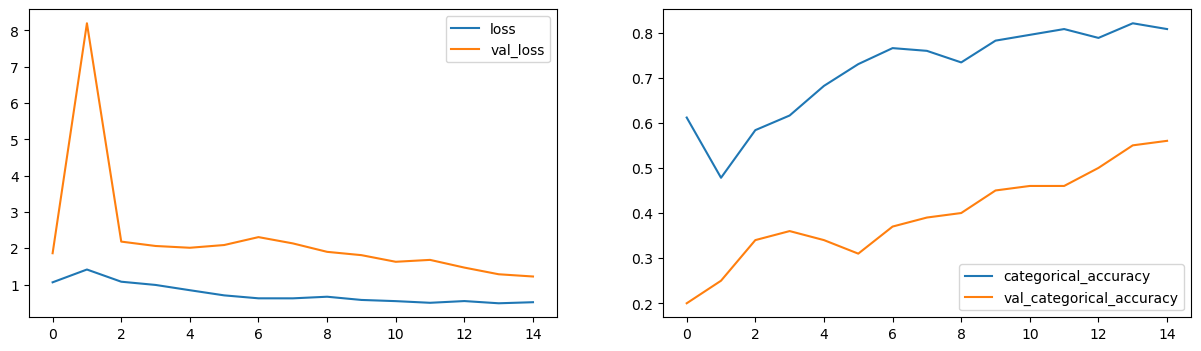

In [150]:
plot(history_model5)

##### All the experimental models above have more than 1 million parameters. Let's try to reduce the model size and see the performance

## Model 6 
### Reducing the number of parameters

In [154]:
class ModelConv3D6(ModelBuilder):
    
    def define_model(self, dense_neurons=64, dropout=0.25):
        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                         input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [155]:
conv_3d6=ModelConv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=100,image_width=100)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20)
conv_3d6_model=conv_3d6.define_model(dense_neurons=128,dropout=0.25)
conv_3d6_model.summary()

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_132 (Conv3D)             │ (None, 16, 100, 100,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_132 (Activation)     │ (None, 16, 100, 100,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_194         │ (None, 16, 100, 100,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_124               │ (None, 8, 50, 50, 16)  │             0 │
│ (MaxPooling3D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_133 (Conv3D)             │ (None, 8, 50, 50, 32)  │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_133 (Activation)     │ (None, 8, 50, 50, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_195         │ (None, 8, 50, 50, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_125               │ (None, 4, 25, 25, 32)  │             0 │
│ (MaxPooling3D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_134 (Conv3D)             │ (None, 4, 25, 25, 64)  │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_134 (Activation)     │ (None, 4, 25, 25, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_196         │ (None, 4, 25, 25, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_126               │ (None, 2, 12, 12, 64)  │             0 │
│ (MaxPooling3D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_135 (Conv3D)             │ (None, 2, 12, 12, 128) │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_135 (Activation)     │ (None, 2, 12, 12, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_197         │ (None, 2, 12, 12, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_127               │ (None, 1, 6, 6, 128)   │             0 │
│ (MaxPooling3D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_31 (Flatten)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_198         │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 696,645 (2.66 MB)

 Trainable params: 695,653 (2.65 MB)

 Non-trainable params: 992 (3.88 KB)

In [156]:
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 696645
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3176 - loss: 1.9077
Epoch 1: val_loss improved from inf to 1.96756, saving model to model_init_2024-07-0300_04_56.428730/model-00001-1.74038-0.36652-1.96756-0.16000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 123s 4s/step - categorical_accuracy: 0.3190 - loss: 1.9029 - val_categorical_accuracy: 0.1600 - val_loss: 1.9676 - learning_rate: 2.0000e-04
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.5180 - loss: 1.2486
Epoch 2: val_loss did not improve from 1.96756
34/34 ━━━━━━━━━━━━━━━━━━━━ 121s 4s/step - categorical_accuracy: 0.5183 - loss: 1.2482 - val_categorical_accuracy: 0.2000 - val_loss: 2.9211 - learning_rate: 2.0000e-04
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.6004 - loss: 1.0225
Epoch 3: val_loss did not improve from 1.96756
34/34 ━━━━━━━━━━━━━━━━━━━━ 121s 4s/step - categorical_accuracy: 0.6007 - loss: 1.0230 - val_categorical_accuracy:

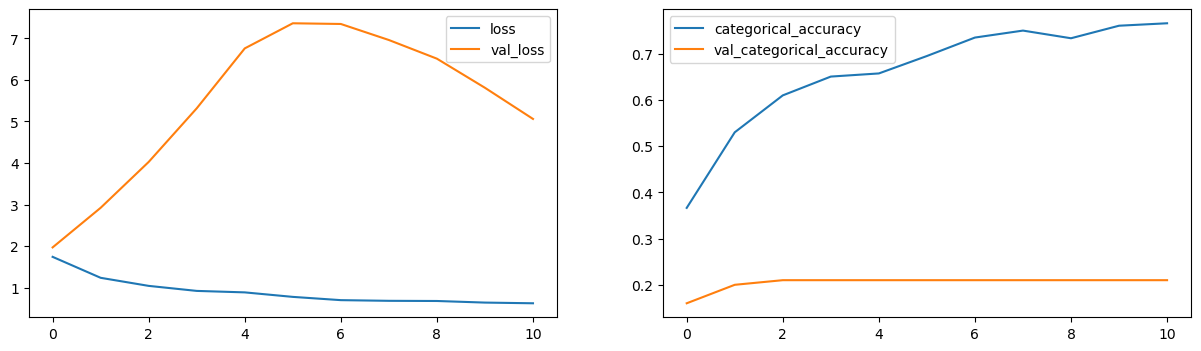

In [157]:
plot(history_model6)

###### For the above low memory foot print model, we get the best validation accuracy of 74%

## Model 7 - Reducing the number of parameters again

In [160]:
class ModelConv3D7(ModelBuilder):
    
    def define_model(self, dense_neurons=64, dropout=0.25):
        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                         input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


In [161]:
conv_3d7=ModelConv3D7()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height=120,image_width=120)
conv_3d7.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d7_model=conv_3d7.define_model(dense_neurons=64,dropout=0.25)
conv_3d7_model.summary()

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_140 (Conv3D)             │ (None, 16, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_140 (Activation)     │ (None, 16, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_206         │ (None, 16, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_132               │ (None, 8, 60, 60, 16)  │             0 │
│ (MaxPooling3D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_141 (Conv3D)             │ (None, 8, 60, 60, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_141 (Activation)     │ (None, 8, 60, 60, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_207         │ (None, 8, 60, 60, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_133               │ (None, 4, 30, 30, 32)  │             0 │
│ (MaxPooling3D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_142 (Conv3D)             │ (None, 4, 30, 30, 64)  │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_142 (Activation)     │ (None, 4, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_208         │ (None, 4, 30, 30, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_134               │ (None, 2, 15, 15, 64)  │             0 │
│ (MaxPooling3D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_143 (Conv3D)             │ (None, 2, 15, 15, 128) │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_143 (Activation)     │ (None, 2, 15, 15, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_209         │ (None, 2, 15, 15, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_135               │ (None, 1, 7, 7, 128)   │             0 │
│ (MaxPooling3D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_33 (Flatten)            │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_210         │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 504,709 (1.93 MB)

 Trainable params: 503,973 (1.92 MB)

 Non-trainable params: 736 (2.88 KB)

In [162]:
print("Total Params:", conv_3d7_model.count_params())
history_model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)

Total Params: 504709
Epoch 1/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.2861 - loss: 2.0649
Epoch 1: val_loss improved from inf to 1.68027, saving model to model_init_2024-07-0309_11_42.723145/model-00001-1.84003-0.34012-1.68027-0.16000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 195s 6s/step - categorical_accuracy: 0.2877 - loss: 2.0585 - val_categorical_accuracy: 0.1600 - val_loss: 1.6803 - learning_rate: 2.0000e-04
Epoch 2/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.4611 - loss: 1.3146
Epoch 2: val_loss did not improve from 1.68027
34/34 ━━━━━━━━━━━━━━━━━━━━ 200s 6s/step - categorical_accuracy: 0.4614 - loss: 1.3146 - val_categorical_accuracy: 0.1600 - val_loss: 1.9842 - learning_rate: 2.0000e-04
Epoch 3/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.5481 - loss: 1.1059
Epoch 3: val_loss did not improve from 1.68027
34/34 ━━━━━━━━━━━━━━━━━━━━ 199s 6s/step - categorical_accuracy: 0.5480 - loss: 1.1071 - val_categorical_accuracy:

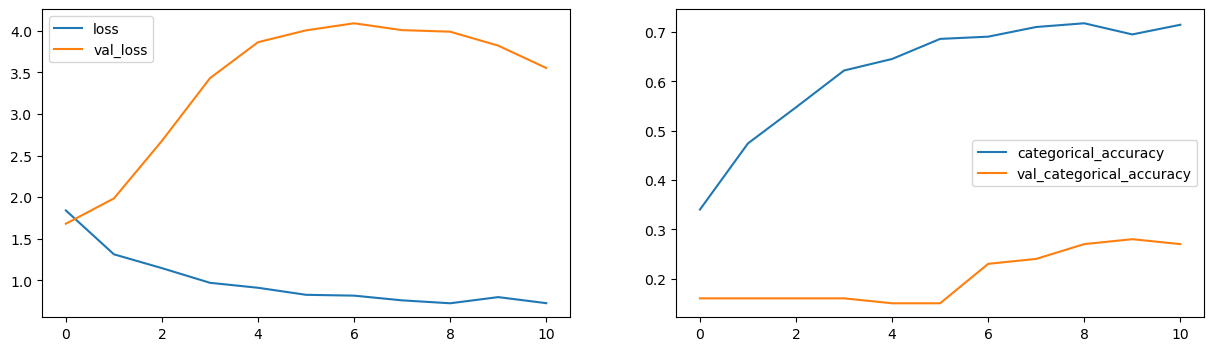

In [163]:
plot(history_model7)

## Model 8 - CNN- LSTM Model

In [73]:
def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc, augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=10, verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences % self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences / self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences // self.batch_size) + 1

        if (self.num_val_sequences % self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences / self.batch_size)
        else:
            validation_steps = (self.num_val_sequences // self.batch_size) + 1

        history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, initial_epoch=0)
        return history


In [74]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [75]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_45             │ (None, 18, 120, 120,   │           448 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_46             │ (None, 18, 120, 120,   │            64 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_47             │ (None, 18, 60, 60, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_48             │ (None, 18, 60, 60, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_49             │ (None, 18, 60, 60, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_50             │ (None, 18, 30, 30, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_51             │ (None, 18, 30, 30, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_52             │ (None, 18, 30, 30, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_53             │ (None, 18, 15, 15, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_54             │ (None, 18, 15, 15,     │        73,856 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_55             │ (None, 18, 15, 15,     │           512 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_56             │ (None, 18, 7, 7, 128)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_57             │ (None, 18, 7, 7, 256)  │       295,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_58             │ (None, 18, 7, 7, 256)  │         1,024 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_59             │ (None, 18, 3, 3, 256)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_60             │ (None, 18, 2304)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │     1,245,69

 Total params: 1,657,445 (6.32 MB)

 Trainable params: 1,656,453 (6.32 MB)

 Non-trainable params: 992 (3.88 KB)

re-rwiting train modle unable to upload mycurrent models

In [76]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model8=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - categorical_accuracy: 0.3166 - loss: 1.5455
Epoch 1: val_loss improved from inf to 1.36265, saving model to model_init_2024-07-1423_33_35.017531/model-00001-1.42969-0.38235-1.36265-0.47000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 243s 7s/step - categorical_accuracy: 0.3185 - loss: 1.5422 - val_categorical_accuracy: 0.4700 - val_loss: 1.3626 - learning_rate: 0.0010
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - categorical_accuracy: 0.4832 - loss: 1.1986
Epoch 2: val_loss improved from 1.36265 to 1.06067, saving model to model_init_2024-07-1423_33_35.017531/model-00002-1.21043-0.47511-1.06067-0.54000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 253s 7s/step - categorical_accuracy: 0.4829 - loss: 1.1989 - val_categorical_accuracy: 0.5400 - val_loss: 1.0607 - learning_rate: 0.0010
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.5535 - loss: 1.0949
Epoch 3: val_loss improved from 1.06067 to 0.91217, saving 

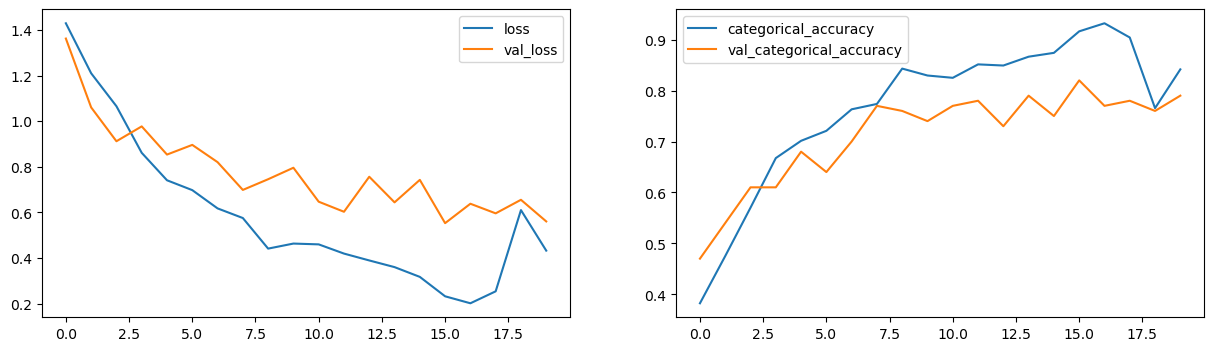

In [77]:
plot(history_model8)

##### For CNN - LSTM model we get a best validation accuracy of 82%

As we see more cases of overfitting, lets augment the data with ***slight rotation*** as well and run the same set of models again

## Let's apply some data augmentation & check the model performance.

In [10]:
class ModelBuilderMoreAugmentation(metaclass=abc.ABCMeta):
    
    def initialize_path(self, project_folder):
        self.train_doc = np.random.permutation(open(os.path.join(project_folder, 'train.csv')).readlines())
        self.val_doc = np.random.permutation(open(os.path.join(project_folder, 'val.csv')).readlines())
        self.train_path = os.path.join(project_folder, 'train')
        self.val_path = os.path.join(project_folder, 'val')
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self, image_height=100, image_width=100):
        self.image_height = image_height
        self.image_width = image_width
        self.channels = 3
        self.num_classes = 5
        self.total_frames = 30
          
    def initialize_hyperparams(self, frames_to_sample=30, batch_size=20, num_epochs=20):
        self.frames_to_sample = frames_to_sample
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        
    def generator(self, source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0, self.total_frames - 1, self.frames_to_sample)).astype(int)
        batch_size = self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t) // batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels = self.one_batch_data(source_path, t, batch, batch_size, img_idx, augment)
                yield batch_data, batch_labels 

            remaining_seq = len(t) % batch_size
        
            if remaining_seq != 0:
                batch_data, batch_labels = self.one_batch_data(source_path, t, num_batches, batch_size, img_idx, augment, remaining_seq)
                yield batch_data, batch_labels 
    
    def one_batch_data(self, source_path, t, batch, batch_size, img_idx, augment, remaining_seq=0):
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len, len(img_idx), self.image_height, self.image_width, self.channels)) 
        batch_labels = np.zeros((seq_len, self.num_classes)) 
    
        if augment:
            batch_data_aug = np.zeros((seq_len, len(img_idx), self.image_height, self.image_width, self.channels))

        for folder in range(seq_len): 
            imgs = os.listdir(os.path.join(source_path, t[folder + (batch * batch_size)].split(';')[0])) 
            for idx, item in enumerate(img_idx): 
                image_path = os.path.join(source_path, t[folder + (batch * batch_size)].strip().split(';')[0], imgs[item])
                image = Image.open(image_path).resize((self.image_height, self.image_width))
                image = np.array(image).astype(np.float32)
                image /= 255.0

                batch_data[folder, idx, :, :, :] = image
            
                if augment:
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30, 30)], [0, 1, np.random.randint(-30, 30)]]), 
                                             (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0)
                    cropped = shifted[x0:x1, y0:y1, :]

                    cropped = cropped.astype(np.uint8)  # Ensure the array is uint8 before conversion
                    image_resized = np.array(Image.fromarray(cropped).resize((self.image_height, self.image_width)))
                    
                    M = cv2.getRotationMatrix2D((self.image_width // 2, self.image_height // 2), np.random.randint(-10, 10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    batch_data_aug[folder, idx, :, :, :] = rotated / 255.0
                
            batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1
    
        if augment:
            batch_data = np.concatenate([batch_data, batch_data_aug])
            batch_labels = np.concatenate([batch_labels, batch_labels])

        return batch_data, batch_labels
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc, augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ', '').replace(':', '_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences % self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences / self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences // self.batch_size) + 1

        if (self.num_val_sequences % self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences / self.batch_size)
        else:
            validation_steps = (self.num_val_sequences // self.batch_size) + 1
    
        history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, initial_epoch=0)
        return history

    @abc.abstractmethod
    def define_model(self):
        pass


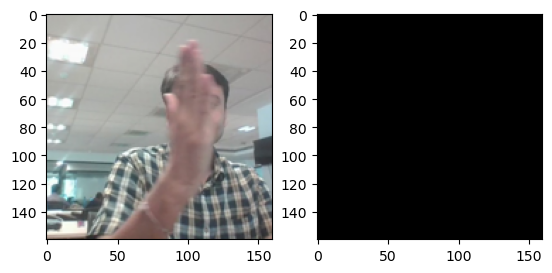

In [18]:
class Test(ModelBuilderMoreAugmentation):
    def define_model(self):
        pass

test_generator=Test()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,29,:,:,:])   
axes[1].imshow(batch_data[3,29,:,:,:])   

## Model 9 with Augmentation
### (3,3,3) Filter & 160x160 Image resolution - similar to Model 2

In [19]:
class ModelConv3D9(ModelBuilderMoreAugmentation):
    
    def define_model(self, filtersize=(3, 3, 3), dense_neurons=64, dropout=0.25):
        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                         input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [182]:
conv_3d9=ModelConv3D9()
conv_3d9.initialize_path(project_folder)
conv_3d9.initialize_image_properties(image_height=160,image_width=160)
conv_3d9.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=20)
conv_3d9_model=conv_3d9.define_model(dense_neurons=256,dropout=0.5)
conv_3d9_model.summary()


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_152 (Conv3D)             │ (None, 20, 160, 160,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_152 (Activation)     │ (None, 20, 160, 160,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_229         │ (None, 20, 160, 160,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_144               │ (None, 10, 80, 80, 16) │             0 │
│ (MaxPooling3D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_153 (Conv3D)             │ (None, 10, 80, 80, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_153 (Activation)     │ (None, 10, 80, 80, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_230         │ (None, 10, 80, 80, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_145               │ (None, 5, 40, 40, 32)  │             0 │
│ (MaxPooling3D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_154 (Conv3D)             │ (None, 5, 40, 40, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_154 (Activation)     │ (None, 5, 40, 40, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_231         │ (None, 5, 40, 40, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_146               │ (None, 2, 20, 20, 64)  │             0 │
│ (MaxPooling3D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_155 (Conv3D)             │ (None, 2, 20, 20, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_155 (Activation)     │ (None, 2, 20, 20, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_232         │ (None, 2, 20, 20, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_147               │ (None, 1, 10, 10, 128) │             0 │
│ (MaxPooling3D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_37 (Flatten)            │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_233         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,638,981 (13.88 MB)

 Trainable params: 3,637,477 (13.88 MB)

 Non-trainable params: 1,504 (5.88 KB)

In [183]:
print("Total Params:", conv_3d9_model.count_params())
history_model9=conv_3d9.train_model(conv_3d9_model,augment_data=True)

Total Params: 3638981
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 58s/step - categorical_accuracy: 0.1893 - loss: 2.6567 
Epoch 1: saving model to model_init_2024-07-0315_12_20.309971/model-00001-2.50164-0.22775-1.64220-0.21000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 1938s 58s/step - categorical_accuracy: 0.1904 - loss: 2.6523 - val_categorical_accuracy: 0.2100 - val_loss: 1.6422 - learning_rate: 2.0000e-04
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 180s/step - categorical_accuracy: 0.2735 - loss: 2.2304  
Epoch 2: saving model to model_init_2024-07-0315_12_20.309971/model-00002-2.18024-0.28205-1.94321-0.21000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 7155s 180s/step - categorical_accuracy: 0.2738 - loss: 2.2290 - val_categorical_accuracy: 0.2100 - val_loss: 1.9432 - learning_rate: 2.0000e-04
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - categorical_accuracy: 0.3099 - loss: 2.1193 
Epoch 3: saving model to model_init_2024-07-0315_12_20.309971/model-00003-2.11183-0.30317-2.47887-0.21000.keras
34/34 ━━

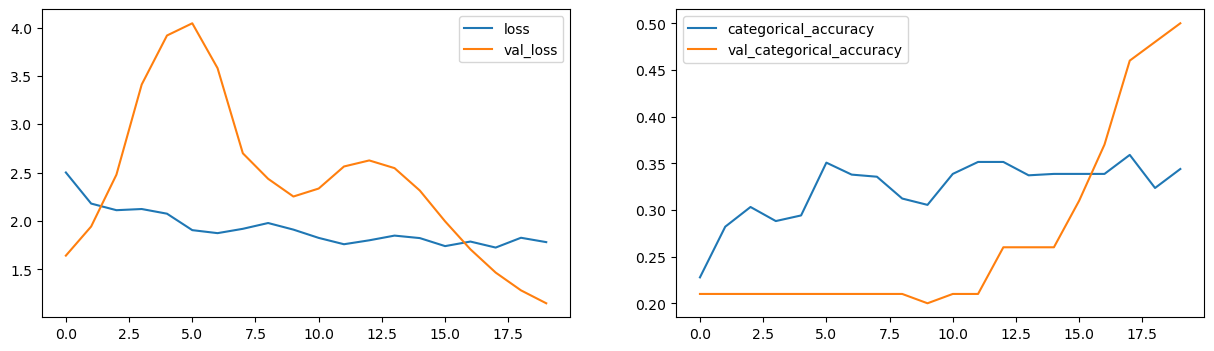

In [184]:
plot(history_model9)

## Model 10 with Augmentation
### (2,2,2) Filter  & 120x120 Image resolution - similar to Model 3

In [187]:
class ModelConv3D10(ModelBuilderMoreAugmentation):
    
    def define_model(self, filtersize=(3, 3, 3), dense_neurons=64, dropout=0.25):
        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                         input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [188]:
conv_3d10=ModelConv3D10()
conv_3d10.initialize_path(project_folder)
conv_3d10.initialize_image_properties(image_height=120,image_width=120)
conv_3d10.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
conv_3d10_model=conv_3d10.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d10_model.summary()

Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_160 (Conv3D)             │ (None, 16, 120, 120,   │           400 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_160 (Activation)     │ (None, 16, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_241         │ (None, 16, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_152               │ (None, 8, 60, 60, 16)  │             0 │
│ (MaxPooling3D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_161 (Conv3D)             │ (None, 8, 60, 60, 32)  │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_161 (Activation)     │ (None, 8, 60, 60, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_242         │ (None, 8, 60, 60, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_153               │ (None, 4, 30, 30, 32)  │             0 │
│ (MaxPooling3D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_162 (Conv3D)             │ (None, 4, 30, 30, 64)  │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_162 (Activation)     │ (None, 4, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_243         │ (None, 4, 30, 30, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_154               │ (None, 2, 15, 15, 64)  │             0 │
│ (MaxPooling3D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_163 (Conv3D)             │ (None, 2, 15, 15, 128) │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_163 (Activation)     │ (None, 2, 15, 15, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_244         │ (None, 2, 15, 15, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_155               │ (None, 1, 7, 7, 128)   │             0 │
│ (MaxPooling3D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_39 (Flatten)            │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_245         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,762,613 (6.72 MB)

 Trainable params: 1,761,109 (6.72 MB)

 Non-trainable params: 1,504 (5.88 KB)

In [189]:
print("Total Params:", conv_3d10_model.count_params())
history_model10=conv_3d10.train_model(conv_3d10_model,augment_data=True)

Total Params: 1762613
Epoch 1/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.2173 - loss: 2.6295
Epoch 1: saving model to model_init_2024-07-0413_48_39.437948/model-00001-2.45319-0.24133-1.63297-0.22000.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 139s 6s/step - categorical_accuracy: 0.2183 - loss: 2.6221 - val_categorical_accuracy: 0.2200 - val_loss: 1.6330 - learning_rate: 2.0000e-04
Epoch 2/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.2977 - loss: 2.1505
Epoch 2: saving model to model_init_2024-07-0413_48_39.437948/model-00002-2.17413-0.28884-1.73340-0.16000.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 141s 6s/step - categorical_accuracy: 0.2973 - loss: 2.1515 - val_categorical_accuracy: 0.1600 - val_loss: 1.7334 - learning_rate: 2.0000e-04
Epoch 3/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.3201 - loss: 2.0053
Epoch 3: saving model to model_init_2024-07-0413_48_39.437948/model-00003-1.98354-0.33107-1.89573-0.16000.keras
23/23 ━━━━━━━━━━━━━━━

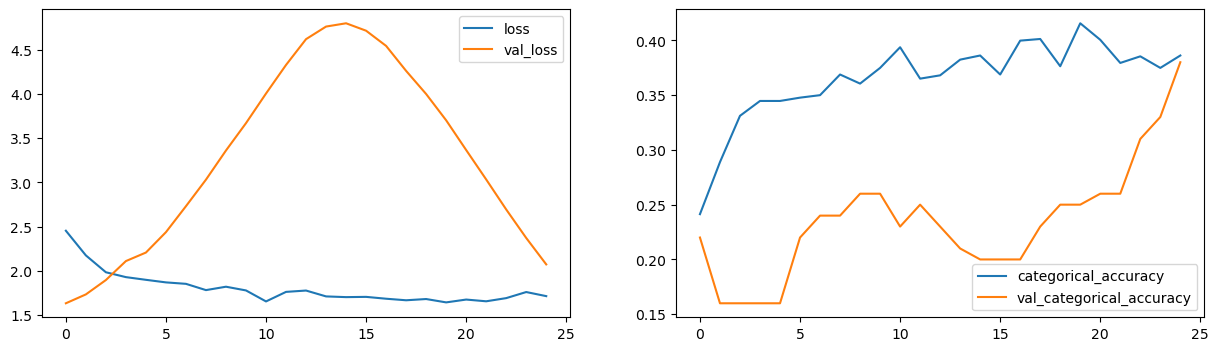

In [190]:
plot(history_model10)

## Model 11 with Augmentation
### Adding more layers - Similar to model 4

In [20]:
class ModelConv3D11(ModelBuilderMoreAugmentation):
    
    def define_model(self, filtersize=(3, 3, 3), dense_neurons=64, dropout=0.25):
        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                         input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [21]:
conv_3d11=ModelConv3D11()
conv_3d11.initialize_path(project_folder)
conv_3d11.initialize_image_properties(image_height=120,image_width=120)
conv_3d11.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d11_model=conv_3d11.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d11_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 16, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 16, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 16, 120, 120,   │         6,928 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 8, 60, 60, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 8, 60, 60, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 8, 60, 60, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 60, 60, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 8, 60, 60, 32)  │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 8, 60, 60, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 60, 60, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 4, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 4, 30, 30, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 4, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 30, 30, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 4, 30, 30, 64)  │       110,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 4, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 30, 30, 64)  │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 2,556,533 (9.75 MB)

 Trainable params: 2,554,549 (9.74 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [22]:
print("Total Params:", conv_3d11_model.count_params())
history_model11=conv_3d11.train_model(conv_3d11_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - categorical_accuracy: 0.2228 - loss: 2.4740 
Epoch 1: saving model to model_init_2024-07-0623_30_27.384263/model-00001-2.45079-0.22775-1.63262-0.21000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 379s 11s/step - categorical_accuracy: 0.2230 - loss: 2.4733 - val_categorical_accuracy: 0.2100 - val_loss: 1.6326 - learning_rate: 2.0000e-04
Epoch 2/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - categorical_accuracy: 0.2894 - loss: 2.2220 
Epoch 2: saving model to model_init_2024-07-0623_30_27.384263/model-00002-2.16029-0.28130-1.87789-0.16000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 392s 12s/step - categorical_accuracy: 0.2892 - loss: 2.2202 - val_categorical_accuracy: 0.1600 - val_loss: 1.8779 - learning_rate: 2.0000e-04
Epoch 3/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - categorical_accuracy: 0.2889 - loss: 2.0805 
Epoch 3: saving model to model_init_2024-07-0623_30_27.384263/model-00003-2.05774-0.29638-2.01313-0.16000.keras
34/34 ━━━━━━━

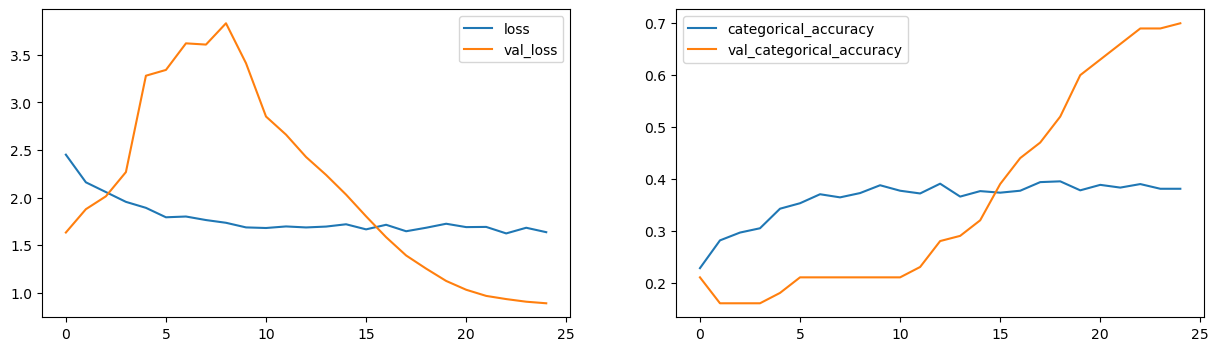

In [23]:
plot(history_model11)

## Model 12 with Augmentation
### Adding dropouts - Similar to Model 5

In [15]:
class ModelConv3D12(ModelBuilderMoreAugmentation):
    
    def define_model(self, filtersize=(3,3,3), dense_neurons=64, dropout=0.25):

        model = Sequential()
        
        # First Convolutional Block
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        # Second Convolutional Block
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        # Third Convolutional Block
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        # Fourth Convolutional Block
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        # Flatten and Dense Layers
        model.add(Flatten())
        
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))
        
        # Compile the model
        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model


In [16]:
conv_3d12=ModelConv3D12()
conv_3d12.initialize_path(project_folder)
conv_3d12.initialize_image_properties(image_height=120,image_width=120)
conv_3d12.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d12_model=conv_3d12.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d12_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_16 (Conv3D)              │ (None, 16, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 16, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 16, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_17 (Conv3D)              │ (None, 16, 120, 120,   │         6,928 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 16, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 16, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_8 (MaxPooling3D)  │ (None, 8, 60, 60, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 8, 60, 60, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_18 (Conv3D)              │ (None, 8, 60, 60, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 8, 60, 60, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 8, 60, 60, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_19 (Conv3D)              │ (None, 8, 60, 60, 32)  │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 8, 60, 60, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 8, 60, 60, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_9 (MaxPooling3D)  │ (None, 4, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 4, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_20 (Conv3D)              │ (None, 4, 30, 30, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 4, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 4, 30, 30, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_21 (Conv3D)              │ (None, 4, 30, 30, 64)  │       110,656 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,556,533 (9.75 MB)

 Trainable params: 2,554,549 (9.74 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [17]:
print("Total Params:", conv_3d12_model.count_params())
history_model12=conv_3d12.train_model(conv_3d12_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - categorical_accuracy: 0.2361 - loss: 2.2673 
Epoch 1: saving model to model_init_2024-07-0911_42_59.137662/model-00001-2.14765-0.24962-1.75074-0.16000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 377s 11s/step - categorical_accuracy: 0.2364 - loss: 2.2639 - val_categorical_accuracy: 0.1600 - val_loss: 1.7507 - learning_rate: 2.0000e-04
Epoch 2/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - categorical_accuracy: 0.2777 - loss: 1.9359 
Epoch 2: saving model to model_init_2024-07-0911_42_59.137662/model-00002-1.86884-0.28507-2.26518-0.16000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 377s 11s/step - categorical_accuracy: 0.2779 - loss: 1.9340 - val_categorical_accuracy: 0.1600 - val_loss: 2.2652 - learning_rate: 2.0000e-04
Epoch 3/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - categorical_accuracy: 0.3059 - loss: 1.8234 
Epoch 3: saving model to model_init_2024-07-0911_42_59.137662/model-00003-1.78364-0.30769-2.73994-0.16000.keras
34/34 ━━━━━━━

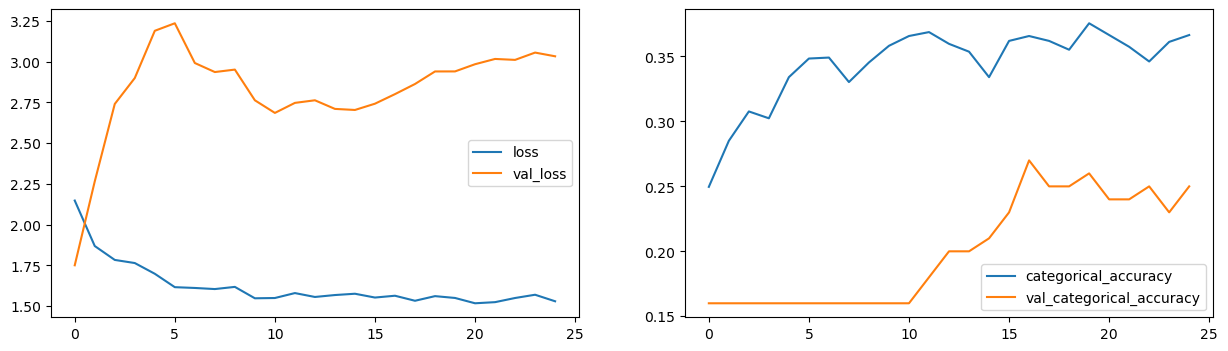

In [18]:
plot(history_model12)

Model is overfitting

## Model 13 with Augmentation
### Reducing network parameters - Similar to Model 6

In [19]:
class ModelConv3D13(ModelBuilderMoreAugmentation):
    
    def define_model(self, dense_neurons=64, dropout=0.25):

        model = Sequential()
        
        # First Convolutional Block
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                         input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Second Convolutional Block
        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Third Convolutional Block
        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Fourth Convolutional Block
        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        # Flatten and Dense Layers
        model.add(Flatten())
        
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))

        # Compile the model
        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

In [20]:
conv_3d13=ModelConv3D13()
conv_3d13.initialize_path(project_folder)
conv_3d13.initialize_image_properties(image_height=100,image_width=100)
conv_3d13.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d13_model=conv_3d13.define_model(dense_neurons=128,dropout=0.25)
conv_3d13_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_24 (Conv3D)              │ (None, 16, 100, 100,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 16, 100, 100,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 16, 100, 100,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_12 (MaxPooling3D) │ (None, 8, 50, 50, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_25 (Conv3D)              │ (None, 8, 50, 50, 32)  │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 8, 50, 50, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 8, 50, 50, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_13 (MaxPooling3D) │ (None, 4, 25, 25, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_26 (Conv3D)              │ (None, 4, 25, 25, 64)  │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 4, 25, 25, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 4, 25, 25, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_14 (MaxPooling3D) │ (None, 2, 12, 12, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_27 (Conv3D)              │ (None, 2, 12, 12, 128) │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 2, 12, 12, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 2, 12, 12, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_15 (MaxPooling3D) │ (None, 1, 6, 6, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 696,645 (2.66 MB)

 Trainable params: 695,653 (2.65 MB)

 Non-trainable params: 992 (3.88 KB)

In [21]:
print("Total Params:", conv_3d13_model.count_params())
history_model13=conv_3d13.train_model(conv_3d13_model,augment_data=True)

Total Params: 696645
Epoch 1/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 70s/step - categorical_accuracy: 0.2169 - loss: 2.1523  
Epoch 1: saving model to model_init_2024-07-0923_02_05.698934/model-00001-1.96766-0.26772-1.70259-0.16000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 2492s 70s/step - categorical_accuracy: 0.2183 - loss: 2.1470 - val_categorical_accuracy: 0.1600 - val_loss: 1.7026 - learning_rate: 2.0000e-04
Epoch 2/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3311 - loss: 1.6719
Epoch 2: saving model to model_init_2024-07-0923_02_05.698934/model-00002-1.68684-0.33183-1.99236-0.16000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 114s 3s/step - categorical_accuracy: 0.3312 - loss: 1.6724 - val_categorical_accuracy: 0.1600 - val_loss: 1.9924 - learning_rate: 2.0000e-04
Epoch 3/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3876 - loss: 1.5250
Epoch 3: saving model to model_init_2024-07-0923_02_05.698934/model-00003-1.58251-0.37255-2.25845-0.16000.keras
34/34 ━━━━━━━━━━━

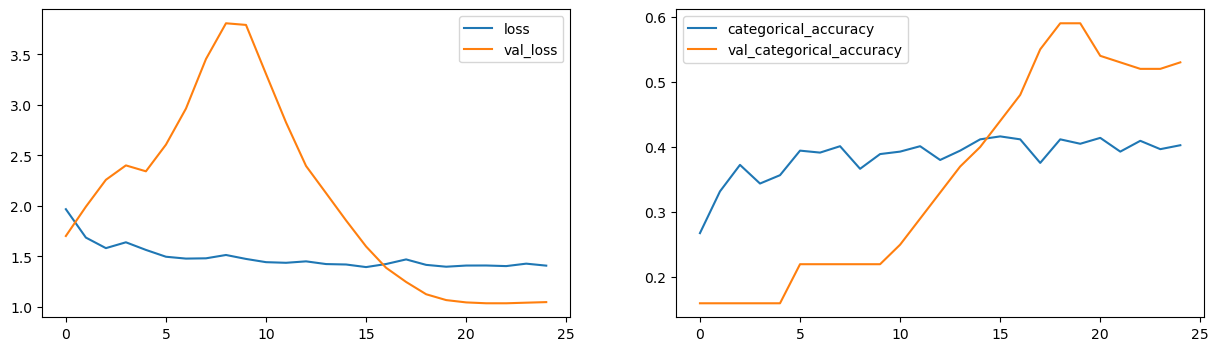

In [22]:
plot(history_model13)

## Model 14 with Augmentation
###  Reducing network parameters again - Similar to model 7

In [23]:
class ModelConv3D14(ModelBuilderMoreAugmentation):
    
    def define_model(self, dense_neurons=64, dropout=0.25):

        model = Sequential()
        
        # First Convolutional Block
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                         input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Second Convolutional Block
        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Third Convolutional Block
        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Fourth Convolutional Block
        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        # Flatten and Dense Layers
        model.add(Flatten())
        
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))

        # Compile the model
        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model


In [24]:
conv_3d14=ModelConv3D14()
conv_3d14.initialize_path(project_folder)
conv_3d14.initialize_image_properties(image_height=120,image_width=120)
conv_3d14.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d14_model=conv_3d14.define_model(dense_neurons=64,dropout=0.25)
conv_3d14_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_28 (Conv3D)              │ (None, 16, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 16, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 16, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_16 (MaxPooling3D) │ (None, 8, 60, 60, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_29 (Conv3D)              │ (None, 8, 60, 60, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 8, 60, 60, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 8, 60, 60, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_17 (MaxPooling3D) │ (None, 4, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_30 (Conv3D)              │ (None, 4, 30, 30, 64)  │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (None, 4, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 4, 30, 30, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_18 (MaxPooling3D) │ (None, 2, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_31 (Conv3D)              │ (None, 2, 15, 15, 128) │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_31 (Activation)      │ (None, 2, 15, 15, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 2, 15, 15, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_19 (MaxPooling3D) │ (None, 1, 7, 7, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 504,709 (1.93 MB)

 Trainable params: 503,973 (1.92 MB)

 Non-trainable params: 736 (2.88 KB)

In [25]:
print("Total Params:", conv_3d14_model.count_params())
history_model14=conv_3d14.train_model(conv_3d14_model,augment_data=True)

Total Params: 504709
Epoch 1/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.2239 - loss: 2.1687
Epoch 1: saving model to model_init_2024-07-1000_29_51.294311/model-00001-2.07226-0.23831-1.65482-0.16000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 188s 6s/step - categorical_accuracy: 0.2243 - loss: 2.1660 - val_categorical_accuracy: 0.1600 - val_loss: 1.6548 - learning_rate: 2.0000e-04
Epoch 2/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.3140 - loss: 1.8740
Epoch 2: saving model to model_init_2024-07-1000_29_51.294311/model-00002-1.82706-0.30845-1.67622-0.17000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 183s 5s/step - categorical_accuracy: 0.3138 - loss: 1.8727 - val_categorical_accuracy: 0.1700 - val_loss: 1.6762 - learning_rate: 2.0000e-04
Epoch 3/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.3412 - loss: 1.6305
Epoch 3: saving model to model_init_2024-07-1000_29_51.294311/model-00003-1.62800-0.34842-1.78133-0.25000.keras
34/34 ━━━━━━━━━━━━━━━━

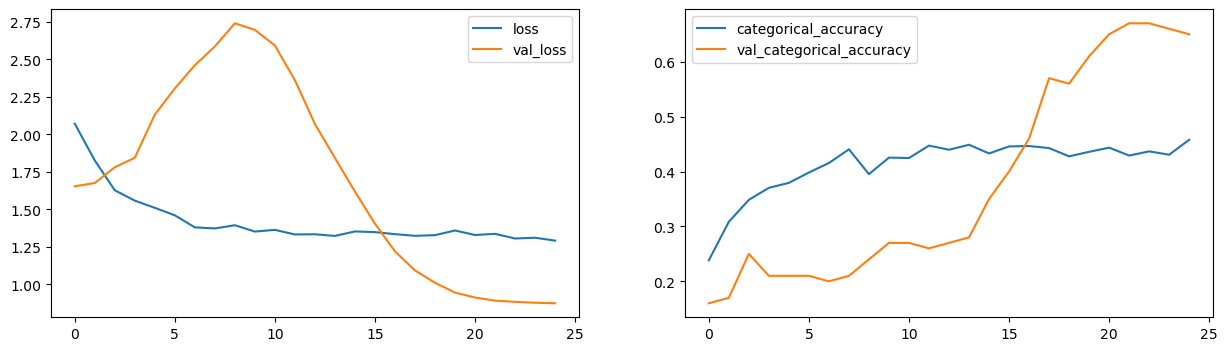

In [26]:
plot(history_model14)

## Model 15 with Augmentation
### CNN LSTM with GRU - Similar to Model 8

In [27]:
class RNNCNN2(ModelBuilderMoreAugmentation):
    
    def define_model(self, lstm_cells=64, dense_neurons=64, dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Flatten()))
        
        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))

        # Compile the model
        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

In [28]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 18, 120, 120,   │           448 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 18, 120, 120,   │            64 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 18, 60, 60, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 18, 60, 60, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 18, 60, 60, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 18, 30, 30, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 18, 30, 30, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 18, 30, 30, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 18, 15, 15, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 18, 15, 15,     │        73,856 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 18, 15, 15,     │           512 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 18, 7, 7, 128)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 18, 6272)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │     2,458,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 2,573,925 (9.82 MB)

 Trainable params: 2,573,445 (9.82 MB)

 Non-trainable params: 480 (1.88 KB)

In [29]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model15=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 2573925
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.2439 - loss: 1.7089
Epoch 1: saving model to model_init_2024-07-1001_45_35.018758/model-00001-1.64041-0.26546-1.52226-0.35000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 276s 8s/step - categorical_accuracy: 0.2445 - loss: 1.7069 - val_categorical_accuracy: 0.3500 - val_loss: 1.5223 - learning_rate: 2.0000e-04
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.3478 - loss: 1.5028
Epoch 2: saving model to model_init_2024-07-1001_45_35.018758/model-00002-1.49627-0.34238-1.13275-0.55000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 270s 8s/step - categorical_accuracy: 0.3476 - loss: 1.5027 - val_categorical_accuracy: 0.5500 - val_loss: 1.1328 - learning_rate: 2.0000e-04
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.3597 - loss: 1.3951
Epoch 3: saving model to model_init_2024-07-1001_45_35.018758/model-00003-1.37773-0.38235-0.96895-0.66000.keras
34/34 ━━━━━━━━━━━━━━━

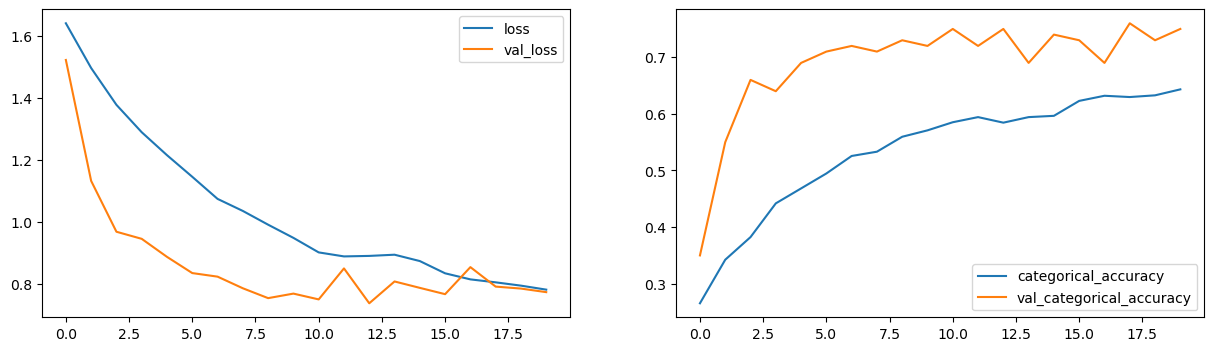

In [30]:
plot(history_model15)

### We see that overfitting is considerably high when we do more augmentation. However there is not much improvement on accuracy

# Consolidated Final Models

## After doing all the experiments, we finalized Model 8 - CNN+LSTM, which performed well.
__Reason:__

__- (Training Accuracy : 91%, Validation Accuracy : 82%)__

__- Number of Parameters(1,657,445)less according to other models performance__


# Loading model and Testing

In [78]:
import os
from keras.models import load_model

# Path to the model
model_path = 'model_init_2024-07-1423_33_35.017531/model-00016-0.23192-0.91629-0.55283-0.82000.keras'

# Load the model
try:
    model = load_model(model_path)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")

Model loaded successfully.


In [79]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_45             │ (None, 18, 120, 120,   │           448 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_46             │ (None, 18, 120, 120,   │            64 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_47             │ (None, 18, 60, 60, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_48             │ (None, 18, 60, 60, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_49             │ (None, 18, 60, 60, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_50             │ (None, 18, 30, 30, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_51             │ (None, 18, 30, 30, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_52             │ (None, 18, 30, 30, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_53             │ (None, 18, 15, 15, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_54             │ (None, 18, 15, 15,     │        73,856 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_55             │ (None, 18, 15, 15,     │           512 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_56             │ (None, 18, 7, 7, 128)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_57             │ (None, 18, 7, 7, 256)  │       295,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_58             │ (None, 18, 7, 7, 256)  │         1,024 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_59             │ (None, 18, 3, 3, 256)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_60             │ (None, 18, 2304)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │     1,245,69

 Total params: 4,970,353 (18.96 MB)

 Trainable params: 1,656,453 (6.32 MB)

 Non-trainable params: 992 (3.88 KB)

 Optimizer params: 3,312,908 (12.64 MB)

In [80]:
test_generator=RNNCNN1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=120,image_width=120)
test_generator.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)

In [81]:
batch_labels

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [82]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step
[2 3 4 2 1 0 4 3 4 0 1 3 2 2 1 4 0 0 4 3]
